In [2]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import snowFun
import dask.array
import sklearn
from sklearn.linear_model import LinearRegression
# %matplotlib widget

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")


# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [4]:
### choose if you want to do only the 45 validation glaciers
validation_only = 1

# choose your rgi to investigate
rgiid = "RGI60-01.01390"   # wolverine:"RGI60-01.09162" RGI60-01.01390

# grab this geometry
rgi_i_gdf = rgi_gdf[rgi_gdf['RGIId']==rgiid].to_crs("EPSG:3338")

# set folder paths
if validation_only:
    folder_sca = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation', 'Band SCFs')
    annual_aa_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'validation', 'Annual AAs')
    annual_ela_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'validation', 'Annual AAs', 'csv')
else:
    folder_sca = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Band SCFs')
    annual_aa_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'Annual AAs')
    annual_ela_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'Annual AAs', 'csv')

# open the snow fraction dataframes
df_snow = pd.read_csv(os.path.join(folder_sca, f"S2_{rgiid}_snow.csv"))#.rename(columns={'Unnamed: 0':"band_n"}).set_index('band_n')
df_observed = pd.read_csv(os.path.join(folder_sca, f"S2_{rgiid}_observed.csv"))#.rename(columns={'Unnamed: 0':"band_n"}).set_index('band_n')

# open end-of-summer data
annual_aa_path = os.path.join(annual_aa_folder, f"S2_{rgiid}_2018_2022_annual_AAs.nc")
annual_aa_xr = xr.open_dataset(annual_aa_path).accumulation_area
annual_ela_path = os.path.join(annual_ela_folder, f"S2_{rgiid}_2018_2022_annual_AAs.csv")
annual_ela_df = pd.read_csv(annual_ela_path)

# subset df_snow and df_observed to only the end of summer dates (plus other metadata)
end_dates = annual_ela_df['date']
meta_cols = ['z_min', 'z_max'] + [f'total_pixels_{y}' for y in range(2018,2023)]
df_snow = df_snow[ meta_cols+list(end_dates.values) ]
df_observed = df_observed[ meta_cols+list(end_dates.values) ]

annual_ela_df.head()

,date,ela,fraction_observed,aar,off_glacier
0,2018-10-01,1420.0,0.986908,0.504809,False
1,2019-09-09,1490.0,0.989680,0.278288,False
2,2020-09-23,1180.0,0.861409,0.719878,False
3,2021-09-15,990.0,0.931265,0.840015,False
4,2022-09-23,950.0,0.957276,0.867986,False


In [6]:
### define function to smooth out the snow cover fraction data a bit
def smooth_the_snow(snow_array, obs_array, width):
    
    # moving window filter to get total snow, total observed, with defined window width
    snow_window = snow_array.rolling(width, min_periods=1, center=True, closed='both').sum()
    obs_window = obs_array.rolling(width, min_periods=1, center=True, closed='both').sum()
    scf_smooth = snow_window/obs_window
    
    return scf_smooth

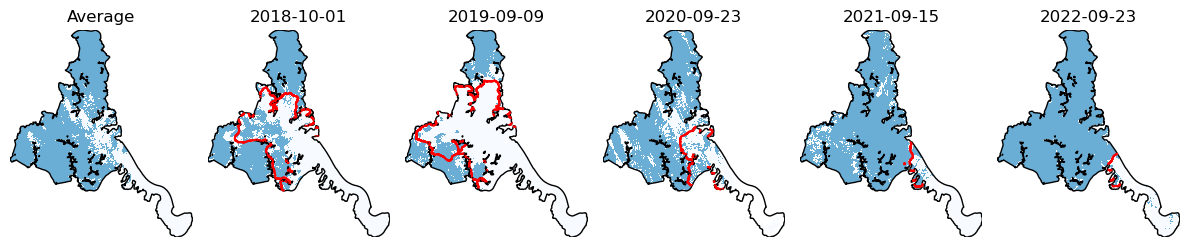

In [5]:
# lets plot the snow cover distribution for each year quickly for a reminder of what it looks like
use_time_varying_dem = 0

fig, axs = plt.subplots(1,6, figsize=(12,4))
for i in range(5):
    y=i+2018
    ax=axs[i+1]
#     if i>0: continue
    
    # open the dem for this year
    if use_time_varying_dem:
        xr_dem = snowFun.get_year_DEM(rgi_i_gdf.geometry, y, smoothed=0)
    else:
        xr_dem = snowFun.get_year_DEM(rgi_i_gdf.geometry, 2013, smoothed=0)
        
    xr_dem = xr.where(xr_dem<=0, np.nan, xr_dem)[0]
    
    # grab the automated aa for this year, date
    aa_y = annual_aa_xr.sel(time=slice(f"{y}-02-01", f"{y}-12-01"))
    t_auto = str(aa_y.time.values[0])[:10]
    
    # get the derived ela
    ela_y = int(annual_ela_df[annual_ela_df['date']==t_auto]['ela'].values[0])

    # add to the figure
    aa_y[0].plot(ax=ax, cmap='Blues', vmin=1, vmax=3, add_colorbar=False)
    rgi_i_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    xr.plot.contour(xr_dem, ax=ax, levels=[ela_y], colors=['red'])
    
    # edit titles, axes, etc...
    ax.set_title(f'{t_auto}')

    ax.axis('off')

### plot the 5-year average 
average_map = annual_aa_xr.median('time', skipna=True).round()#.astype('uint8')
average_map.plot(ax=axs[0], cmap='Blues', vmin=1, vmax=3, add_colorbar=False)
rgi_i_gdf.boundary.plot(ax=axs[0], edgecolor='black', linewidth=1)
axs[0].set_title('Average')
axs[0].axis('off')

plt.tight_layout()

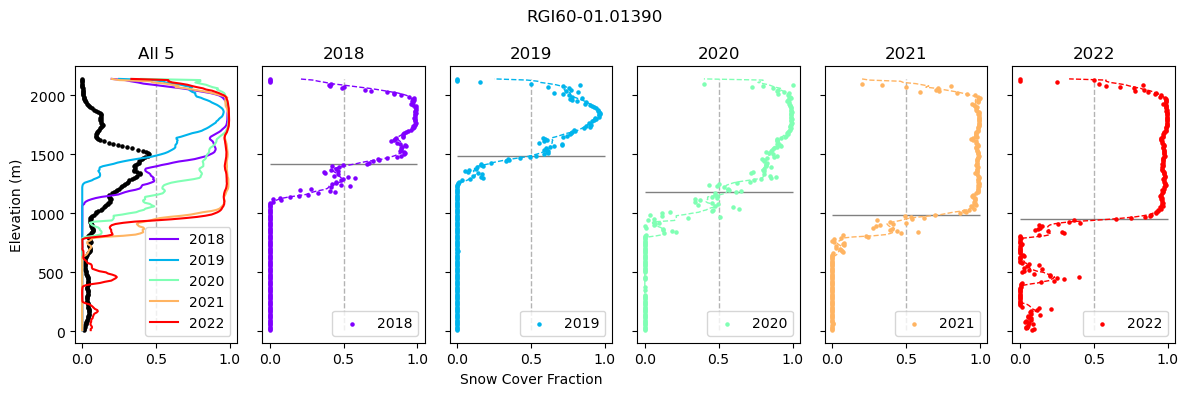

In [7]:
# lets plot the elevation vs snowcover relationship for each year
# we save the first axis to have all five plotted together
fig,axs = plt.subplots(1,6, figsize=(12,4), sharey=True, sharex=True)

# define colors to use
cmap = plt.get_cmap('rainbow', 5)

# get data that doesnt change year to year
zs = df_snow['z_min'] # elevation
total_pixels = df_snow['total_pixels_2018'] # hypsometry

# smooth out the hypsometry data a bit
smooth_hypsometry = total_pixels.rolling(5, min_periods=1, center=True, closed='both').mean()

# calculate cumulative hypsometry
hypsometry_cumulative = total_pixels.cumsum() / total_pixels.sum()

for i in range(5):
    
    # set axis
    ax = axs[i+1]
    
    # get data
    snow_y = df_snow[end_dates[i]] # snow area
    obs_y = df_observed[end_dates[i]] # observed area
    ela_y = annual_ela_df.iloc[i]['ela']
    
    # calculate snow cover fraction for each band
    scf_y = snow_y/obs_y
    
    # calculate a smoothed scf using moving-window operations
    scf_smooth = smooth_the_snow(snow_y, obs_y, 7)
    
    # plot snow cover fractions on their own axis 
    ax.scatter(scf_y, zs, s=5, zorder=5, color=cmap(i), label=2018+i)
    ax.plot(scf_smooth, zs, zorder=5, color=cmap(i), linestyle='dashed', linewidth=1)
    
    # horizontal line at the calculated ela
    ax.hlines([ela_y], xmin=0, xmax=1, colors='grey', linewidths=1)
    
    # plot on shared axis too
    axs[0].plot(scf_smooth, zs, zorder=5, color=cmap(i), label=2018+i)
    
    # faint line at the 0.5 threshold
    ax.plot([0.5,0.5], [min(zs),max(zs)], linestyle='dashed', c='0.7', linewidth=1, zorder=1)
    
    # title and legend
    ax.set_title(2018+i)
    ax.legend(loc='lower right')

# add in the glacier hypsometry
axs[0].scatter(smooth_hypsometry/(max(smooth_hypsometry)*2.2), zs, s=5, zorder=3, color='black')
# axs[0].plot(hypsometry_cumulative, zs, linestyle='dashed', c='0.1', linewidth=1, zorder=1, label='Hyps.')

# combined-plot specific stuff
axs[0].set_title('All 5')
axs[0].plot([0.5,0.5], [min(zs),max(zs)], linestyle='dashed', c='0.7', linewidth=1, zorder=1)
axs[0].legend(loc='lower right')

# group labels
axs[0].set_ylabel('Elevation (m)')
axs[2].set_xlabel('Snow Cover Fraction')
fig.suptitle(rgiid)
plt.tight_layout()

### Lets think about how we can quantify how 'sharp' the ELA/snowline is. Does the glacier go very quickly from fully ablation area to fully accumulation area are you pass the ELA, or is it more of a gradual progression?

#### Maybe we can think about this by looking at the distribution of snow cover fractions. A sharp transition would have only 0s and 1s. A gradual transition would have more bands within the 0.4-0.6 range

In [ ]:
fig,axs = plt.subplots(1,5, figsize=(10,2.5), sharey=True, sharex=True)

# define colors to use
cmap = plt.get_cmap('rainbow', 5)

# get data that doesnt change year to year
zs = df_snow['z_min'] # elevation
total_pixels = df_snow['total_pixels'] # hypsometry

# smooth out the hypsometry data a bit
smooth_hypsometry = total_pixels.rolling(5, min_periods=1, center=True, closed='both').mean()

# calculate cumulative hypsometry
hypsometry_cumulative = total_pixels.cumsum() / total_pixels.sum()

for i in range(5):
    
    # set axis
    ax = axs[i]
    
    # get data
    snow_y = df_snow[end_dates[i]] # snow area
    obs_y = df_observed[end_dates[i]] # observed area
    ela_y = annual_ela_df.iloc[i]['ela']
    
    # calculate snow cover fraction for each band
    scf_y = snow_y/obs_y
    
    # calculate a smoothed scf using moving-window operations
    scf_smooth = smooth_the_snow(snow_y, obs_y, 7)
    
    # show histogram with binning in 0.1 increments
    bins = np.arange(0, 1.01, 0.1)
    ax.hist(scf_smooth, bins=bins, density=False, color=cmap(i))
    
    # title and legend
    ax.set_title(2018+i)

# group labels
axs[0].set_ylabel('Frequency')
axs[2].set_xlabel('Snow Cover Fraction')
fig.suptitle("Snow Cover Fraction Distribution (Full Glacier)")
plt.tight_layout()

#### What if we only look at the section of the glacier immediately around the ELA?

In [ ]:


# define colors to use
cmap = plt.get_cmap('rainbow', 5)

# get data that doesnt change year to year
zs = df_snow['z_min'] # elevation
total_pixels = df_snow['total_pixels'] # hypsometry

# smooth out the hypsometry data a bit
smooth_hypsometry = total_pixels.rolling(5, min_periods=1, center=True, closed='both').mean()

# calculate cumulative hypsometry
hypsometry_cumulative = total_pixels.cumsum() / total_pixels.sum()

fig,axs = plt.subplots(1,5, figsize=(10,2), sharey=True, sharex=True)
for i in range(5):
    
    # set axis
    ax = axs[i]
    
    # get data
    snow_y = df_snow[end_dates[i]] # snow area
    obs_y = df_observed[end_dates[i]] # observed area
    ela_y = annual_ela_df.iloc[i]['ela']
    
    # calculate snow cover fraction for each band
    scf_y = snow_y/obs_y
    
    # calculate a smoothed scf using moving-window operations
    scf_smooth = smooth_the_snow(snow_y, obs_y, 7)
    
    # subset scf to the area around the ela
    offset_up = 200
    offset_down = 200
    scf_subset = scf_smooth[ (zs>=ela_y-offset_down) & (zs<=ela_y+offset_up)]
    
    # show histogram with binning in 0.1 increments
    bins = np.arange(0, 1.01, 0.1)
    ax.hist(scf_subset, bins=bins, density=False, color=cmap(i))
    
    # title and legend
    ax.set_title(2018+i)

# group labels
axs[0].set_ylabel("Snow Cover Fraction\nUp and Down from ELA")
axs[2].set_xlabel('Snow Cover Fraction')
plt.tight_layout()


fig,axs = plt.subplots(1,5, figsize=(10,2), sharey=True, sharex=True)
for i in range(5):
    
    # set axis
    ax = axs[i]
    
    # get data
    snow_y = df_snow[end_dates[i]] # snow area
    obs_y = df_observed[end_dates[i]] # observed area
    ela_y = annual_ela_df.iloc[i]['ela']
    
    # calculate snow cover fraction for each band
    scf_y = snow_y/obs_y
    
    # calculate a smoothed scf using moving-window operations
    scf_smooth = smooth_the_snow(snow_y, obs_y, 7)
    
    # subset scf to the area around the ela
    offset_up = 1
    offset_down = 200
    scf_subset = scf_smooth[ (zs>=ela_y-offset_down) & (zs<=ela_y+offset_up)]
    
    # show histogram with binning in 0.1 increments
    bins = np.arange(0, 1.01, 0.1)
    ax.hist(scf_subset, bins=bins, density=False, color=cmap(i))
    
    # title and legend
    ax.set_title(2018+i)

# group labels
axs[0].set_ylabel("Snow Cover Fraction\nELA and Down")
axs[2].set_xlabel('Snow Cover Fraction')
plt.tight_layout()


fig,axs = plt.subplots(1,5, figsize=(10,2), sharey=True, sharex=True)
for i in range(5):
    
    # set axis
    ax = axs[i]
    
    # get data
    snow_y = df_snow[end_dates[i]] # snow area
    obs_y = df_observed[end_dates[i]] # observed area
    ela_y = annual_ela_df.iloc[i]['ela']
    
    # calculate snow cover fraction for each band
    scf_y = snow_y/obs_y
    
    # calculate a smoothed scf using moving-window operations
    scf_smooth = smooth_the_snow(snow_y, obs_y, 7)
    
    # subset scf to the area around the ela
    offset_up = 200
    offset_down = 1
    scf_subset = scf_smooth[ (zs>=ela_y-offset_down) & (zs<=ela_y+offset_up)]
    
    # show histogram with binning in 0.1 increments
    bins = np.arange(0, 1.01, 0.1)
    ax.hist(scf_subset, bins=bins, density=False, color=cmap(i))
    
    # title and legend
    ax.set_title(2018+i)

# group labels
axs[0].set_ylabel("Snow Cover Fraction\nELA and Up")
axs[2].set_xlabel('Snow Cover Fraction')
plt.tight_layout()